# Define the pyrion project

In [1]:
from pyiron_continuum import Project
from damask import Rotation # this will be used in material configuration

## create a 'project' to manage all the configurations for a Rolling test

In [2]:
pr = Project('RollingTest')
#pr.remove_jobs(silently=True) # automatically delete the existing project folder

## Creating the Damask job

In [3]:
job = pr.create.job.ROLLING('damask_job')

## For a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

## For material configuration
- Query the material parameters for **Elasticity** and **Plasticity** from Data Space Management System(DSMS)

In [4]:
dataset_id="6d66a588-079a-4436-8ac6-dff62c67791b"

query=f"""
prefix emmo: <http://emmo.info/emmo#>
prefix datamodel: <http://emmo.info/datamodel#>
prefix metro: <http://emmo.info/emmo/middle/metrology#>
prefix math: <http://emmo.info/emmo/middle/math#>
prefix perceptual: <http://emmo.info/emmo/middle/perceptual#>
prefix dcat: <http://www.w3.org/ns/dcat#>
prefix steel: <https://w3id.org/steel/ProcessOntology/>
select distinct
    ?param_type
    ?label
    (str(?value) as ?val)
    (str(?unit) as ?unit_label)
where {{
   <https://stahldigital.materials-data.space/{dataset_id}/dataset> datamodel:composition ?param .
    ?param rdf:type ?param_type ;
           rdfs:label ?label ;
           metro:EMMO_8ef3cd6d_ae58_4a8d_9fc0_ad8f49015cd0 ?numerical .
    ?numerical rdf:type math:EMMO_4ce76d7f_03f8_45b6_9003_90052a79bfaa ;
                     math:EMMO_faf79f53_749d_40b2_807c_d34244c192f4 ?value ;
                     metro:EMMO_67fc0a36_8dcb_4ffa_9a43_31074efa3296 ?symbol .
    ?symbol perceptual:EMMO_23b579e1_8088_45b5_9975_064014026c42 ?unit .
}}
"""

In [5]:
import requests
import pandas as pd
import numpy as np

# set host variable
host = "stahldigital.materials-data.space"

# perform query
response = requests.post(f"https://{host}/api/knowledge/sparql", json={"query": query})

# parse into pandas df
df = pd.read_json(response.json()['sparql'], orient='index')
df = df.astype(str)
df = df.applymap(lambda x: x.replace('"', ''))
df.sort_values("label")

,param_type,label,val,unit_label
3,<http://emmo.info/datamodel#Metadata>,Density@en,1.0E0,SomeUnitSymbol
18,<http://emmo.info/datamodel#EnrichedParameter>,Density@en,1.0E0,SomeUnitSymbol
36,<http://emmo.info/emmo/middle/metrology#EMMO_f...,Messlänge Standardweg,8.0E1,mm
40,<http://emmo.info/datamodel#Metadata>,Messlänge Standardweg,8.0E1,mm
29,<http://emmo.info/datamodel#EnrichedParameter>,Poisson ratio@en,1.0E0,SomeUnitSymbol
11,<http://emmo.info/datamodel#Metadata>,Poisson ratio@en,1.0E0,SomeUnitSymbol
35,<http://emmo.info/emmo/middle/metrology#EMMO_f...,Probenbreite,2.0015E1,mm
39,<http://emmo.info/datamodel#Metadata>,Probenbreite,2.0015E1,mm
41,<http://emmo.info/datamodel#Metadata>,Probendicke,1.513E0,mm
37,<http://emmo.info/emmo/middle/metrology#EMMO_f...,Probendicke,1.513E0,mm


In [6]:
E=float(np.asarray(df.loc[df['label'] == 'Youngs modulus@en','val'])[1])*175*1.0e9 # GPa
nu=float(np.asarray(df.loc[df['label'] == 'Poisson ratio@en','val'])[1])*0.3 # Poisson ratio

K=E/(3*(1-2*nu))
mu=E/(2*(1+nu))

C11=K+4*mu/3.0
C12=K-2*mu/3.0
C44=mu

Hardening=float(np.asarray(df.loc[df['label'] == 'hardening moduli@en','val'])[1])*1.0e6 # unit is MPa
Y0=float(np.asarray(df.loc[df['label'] == 'initial flow stress@en','val'])[1])*1.0e6 # unit is MPa
Yinf=float(np.asarray(df.loc[df['label'] == 'saturation flow stress@en','val'])[1])*1.0e6 # unit is MPa
a=float(np.asarray(df.loc[df['label'] == 'stress exponent@en','val'])[1]) # 
n=float(np.asarray(df.loc[df['label'] == 'flow stress exponent@en','val'])[1]) #

### Put the values in Damask job

In [7]:
elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= C11,C_12= C12, C_44=C44)
plasticity = pr.continuum.damask.Plasticity(type='phenopowerlaw',
                                            N_sl=[12], a_sl=a,
                                            atol_xi=1.0, dot_gamma_0_sl=0.001,
                                            h_0_sl_sl=Hardening, h_sl_sl=[1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                                            n_sl=n, output=['xi_sl'],
                                            xi_0_sl=[Y0], xi_inf_sl=[Yinf])

## For material configuration, you need
* phase
* roation
* homogenization

In [8]:
grains = 4
grids = 4

phase = pr.continuum.damask.Phase(composition='Steel', lattice= 'cF',
                         output_list=['F', 'P', 'F_e', 'F_p', 'L_p', 'O'],
                         elasticity=elasticity,plasticity=plasticity)
rotation = pr.continuum.damask.Rotation(Rotation.from_random, grains)

homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                     parameters={'N_constituents': 1,
                                                                 "mechanical": {"type": "pass"}})

# now you can define your material.yaml configuration
material = pr.continuum.damask.Material([rotation],['Steel'], phase, homogenization)

# now you can save your material to your job
job.material = material

## For geometry information

In [9]:
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=10.0e-6, grid_dim=grids, num_grains=grains)

# save the geometry information to your job
job.grid = grid 

# Define the 1st rolling test

In [10]:
reduction_height = 0.08
reduction_speed = 4.5e-2
reduction_outputs = 150
regrid_flag=False
damask_exe = '' # using default DAMASK_grid solver from PATH

# execute the rolling test
job.executeRolling(reduction_height,reduction_speed,reduction_outputs,regrid_flag,damask_exe)

working dir: /home/ybai/Projects/GitHub/pyiron_continuum/notebooks/RollingTest/damask_job_hdf5/damask_job
solver: {mechanical: spectral_basic}

loadstep:
  - boundary_conditions:
      mechanical:
        P:
          - [0, x, x]
          - [x, x, x]
          - [x, x, x]
        dot_F:
          - [x, 0, 0]
          - [0, 0, 0]
          - [0, 0, -0.045]
    discretization: {t: 1.777777777777778, N: 150}
    f_out: 5
    f_restart: 5

Start the first rolling test ...
First rolling test is done !


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


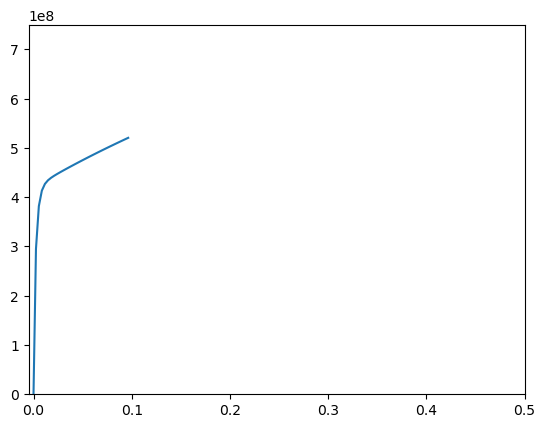

In [11]:
# show the result
job.postProcess() # do the postprocess
job.plotStressStrainCurve(-0.005,0.5,0.0,7.5e8) # xmin,xmax, ymin,ymax

# Define the 2nd rolling test

In [12]:
reduction_height = 0.08
reduction_speed = 4.5e-2
reduction_outputs = 300
regrid_flag=True
damask_exe = '' # using default DAMASK_grid solver from PATH

# execute the rolling test
job.executeRolling(reduction_height,reduction_speed,reduction_outputs,regrid_flag,damask_exe)

------------------------
Start to regrid the geometry ...
initial RVE size:	 [1.e-05 1.e-05 1.e-05]
regridded RVE size:	 [1.084933e-05 1.000000e-05 9.200000e-06]
initial grid seeds:	 [4 4 4]
regridded grid seeds:	 [5 4 4]
finding the nearest neighbors...
all the information are ready !
save regrid geometry to damask_regridded_increment_150.vti
removing the existing restart file.
A regridding history file is created.
------------------------
Regridding process is completed.
Start the rolling-2 test ...
Rolling-2 test is done !


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


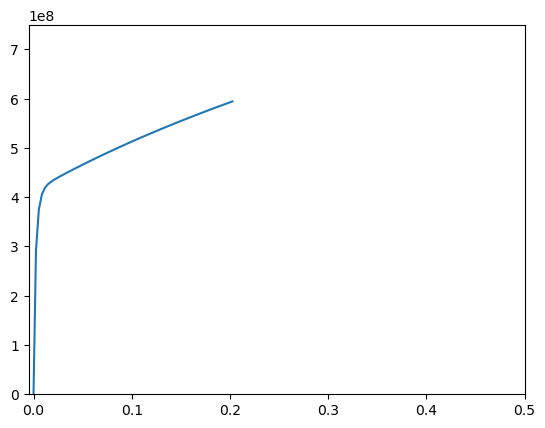

In [13]:
# show the result
job.postProcess() # do the postprocess
job.plotStressStrainCurve(-0.005,0.5,0.0,7.5e8) # xmin,xmax, ymin,ymax

# Define the 3rd rolling test

In [14]:
reduction_height = 0.085
reduction_speed = 4.5e-2
reduction_outputs = 350
regrid_flag=True
damask_exe = '' # using default DAMASK_grid solver from PATH

# execute the rolling test
job.executeRolling(reduction_height,reduction_speed,reduction_outputs,regrid_flag,damask_exe)

------------------------
Start to regrid the geometry ...
initial RVE size:	 [1.084933e-05 1.000000e-05 9.200000e-06]
regridded RVE size:	 [1.28883815e-05 1.00000000e-05 7.72800000e-06]
initial grid seeds:	 [5 4 4]
regridded grid seeds:	 [7 5 4]
finding the nearest neighbors...
all the information are ready !
save regrid geometry to damask_regridded_increment_150_regridded_increment_450.vti
removing the existing restart file.
A regridding history file is created.
------------------------
Regridding process is completed.
Start the rolling-3 test ...
Rolling-3 test is done !


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


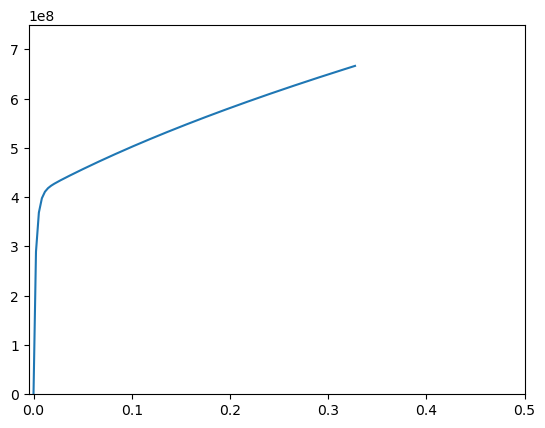

In [15]:
# show the result
job.postProcess() # do the postprocess
job.plotStressStrainCurve(-0.005,0.5,0.0,7.5e8) # xmin,xmax, ymin,ymax

# Define the 4th rolling test

In [16]:
reduction_height = 0.085
reduction_speed = 4.5e-2
reduction_outputs = 350
regrid_flag=True
damask_exe = '' # using default DAMASK_grid solver from PATH

# execute the rolling test
job.executeRolling(reduction_height,reduction_speed,reduction_outputs,regrid_flag,damask_exe)

------------------------
Start to regrid the geometry ...
initial RVE size:	 [1.28883815e-05 1.00000000e-05 7.72800000e-06]
regridded RVE size:	 [1.70302409e-05 1.00000000e-05 5.83464000e-06]
initial grid seeds:	 [7 5 4]
regridded grid seeds:	 [12  7  4]
finding the nearest neighbors...
all the information are ready !
save regrid geometry to damask_regridded_increment_150_regridded_increment_450_regridded_increment_800.vti
removing the existing restart file.
A regridding history file is created.
------------------------
Regridding process is completed.
Start the rolling-4 test ...
Rolling-4 test is done !


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


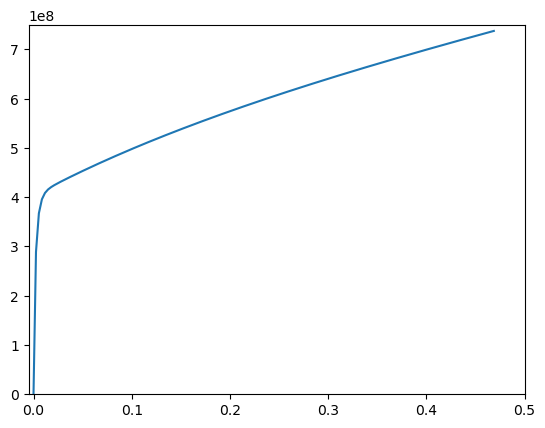

In [17]:
# show the result
job.postProcess() # do the postprocess
job.plotStressStrainCurve(-0.005,0.5,0.0,7.5e8) # xmin,xmax, ymin,ymax

In [18]:
# List out all the hdf5 results file
print(job.ResultsFile)

['damask_load.hdf5', 'damask_regridded_increment_150_load_rolling2.hdf5', 'damask_regridded_increment_150_regridded_increment_450_load_rolling3.hdf5', 'damask_regridded_increment_150_regridded_increment_450_regridded_increment_800_load_rolling4.hdf5']
